# SETUP

In [2]:
!rm -rf ../coco/coco_AttnGAN2.pth
!cp ../coco_AttnGAN2.pth ../coco/

In [3]:
import pandas as pd
import numpy as np
from __future__ import print_function
import nltk
import warnings
warnings.filterwarnings('ignore')
# nltk.download('all')

In [4]:
captions = pd.read_excel('../captions.xlsx')
captions.columns = [u'id', u'image_id', u'CAPTIONS', u'Unnamed: 3']
captions.image_id = captions.image_id.apply(lambda x: x.replace('.jpg',''))
captions.head()

,id,image_id,CAPTIONS,Unnamed: 3
0,1,image_1,a street view looking at the culture center.,MÉCA Cultural Center / BIG
1,2,image_1,a street view looking at a white building with...,NaN
2,3,image_1,a white folded building with urban platform go...,NaN
3,4,image_1,urban platform goes through the middle of a wh...,NaN
4,5,image_1,a building with white stone panel and a big en...,NaN


In [5]:
from miscc.config import cfg, cfg_from_file
from datasets import TextDataset
from trainer import condGANTrainer as trainer

In [6]:
import os
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [7]:
cfg_from_file('cfg/coco.yml')

In [8]:
cfg.GPU_ID = 0
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
if cfg.CUDA:
    torch.cuda.manual_seed_all(100)

now = datetime.datetime.now(dateutil.tz.tzlocal())
timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
output_dir = '../output/%s_%s_%s' % (cfg.DATASET_NAME, cfg.CONFIG_NAME, timestamp)

split_dir, bshuffle = 'images', True

In [9]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM - 1))
image_transform = transforms.Compose([
    transforms.Scale(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
from miscc.config import cfg

import torch
import torch.utils.data as data
from torch.autograd import Variable
import torchvision.transforms as transforms

import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import numpy.random as random
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle
    
from __future__ import print_function
from six.moves import range

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

from PIL import Image

from miscc.config import cfg
from miscc.utils import mkdir_p
from miscc.utils import build_super_images, build_super_images2
from miscc.utils import weights_init, load_params, copy_G_params
from miscc.utils import *
from model import G_DCGAN, G_NET
from datasets import prepare_data
from model import RNN_ENCODER, CNN_ENCODER

from miscc.losses import words_loss
from miscc.losses import discriminator_loss, generator_loss, KL_loss
import os
import time
import numpy as np
import sys

In [24]:
class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train',
                 base_size=64,
                 transform=None, target_transform=None):
        self.transform = transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.target_transform = target_transform
        self.embeddings_num = cfg.TEXT.CAPTIONS_PER_IMAGE

        self.imsize = []
        for i in range(cfg.TREE.BRANCH_NUM):
            self.imsize.append(base_size)
            base_size = base_size * 2

        self.data = []
        self.data_dir = data_dir
        if data_dir.find('birds') != -1:
            self.bbox = self.load_bbox()
        else:
            self.bbox = None
        split_dir = os.path.join(data_dir, split)

        self.filenames, self.captions, self.ixtoword, \
            self.wordtoix, self.n_words = self.load_text_data(data_dir, split)

        self.class_id = self.load_class_id(split_dir, len(self.filenames))
        self.number_example = len(self.filenames)

    def load_bbox(self):
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'CUB_200_2011/bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)
        #
        filepath = os.path.join(data_dir, 'CUB_200_2011/images.txt')
        df_filenames = \
            pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
        #
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in xrange(0, numImgs):
            # bbox = [x-left, y-top, width, height]
            bbox = df_bounding_boxes.iloc[i][1:].tolist()

            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        #
        return filename_bbox
    
    def load_captions(self, data_dir, filenames):
        all_captions = []
        for caption in captions.CAPTIONS:
            tokenizer = RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(caption.lower())
            tokens_new = []
            for t in tokens:
                t = t.encode('ascii', 'ignore').decode('ascii')
                if len(t) > 0:
                    tokens_new.append(t)
            all_captions.append(tokens_new)
        return all_captions
    
            
    def build_dictionary(self, train_captions, test_captions):
        word_counts = defaultdict(float)
        captions = train_captions + test_captions
        for sent in captions:
            for word in sent:
                word_counts[word] += 1
        
        with open('wordtoix.pickle', 'rb') as handle:
            wordtoix = pickle.load(handle)
        with open('ixtoword.pickle', 'rb') as handle:
            ixtoword = pickle.load(handle)

        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            train_captions_new.append(rev)

        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            test_captions_new.append(rev)

        return [train_captions_new, test_captions_new,
                ixtoword, wordtoix, len(ixtoword)]

    def load_text_data(self, data_dir, split):
        filepath = os.path.join(data_dir, 'captions.pickle')
        captions = pd.read_excel('../captions.xlsx')
        captions.columns = [u'id', u'image_id', u'CAPTIONS', u'Unnamed: 3']
        captions.image_id = captions.image_id.apply(lambda x: x.replace('.jpg',''))
        train_names = captions.image_id
        test_names = captions.image_id

        train_captions = self.load_captions(data_dir, train_names)
        test_captions = self.load_captions(data_dir, test_names)

        train_captions, test_captions, ixtoword, wordtoix, n_words = \
            self.build_dictionary(train_captions, test_captions)
        with open(filepath, 'wb') as f:
            pickle.dump([train_captions, test_captions,
                         ixtoword, wordtoix], f, protocol=2)
            print('Save to: ', filepath)
            
            # a list of list: each list contains
            # the indices of words in a sentence
        captions = train_captions
        filenames = train_names
        return filenames, captions, ixtoword, wordtoix, n_words

    def load_class_id(self, data_dir, total_num):
        if os.path.isfile(data_dir + '/class_info.pickle'):
            with open(data_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f)
        else:
            class_id = np.arange(total_num)
        return class_id

    def get_caption(self, sent_ix):
        # a list of indices for a sentence
        sent_caption = np.asarray(self.captions[sent_ix]).astype('int64')
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)
        num_words = len(sent_caption)
        # pad with 0s (i.e., '<end>')
        x = np.zeros((cfg.TEXT.WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= cfg.TEXT.WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
            np.random.shuffle(ix)
            ix = ix[:cfg.TEXT.WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = cfg.TEXT.WORDS_NUM
        return x, x_len

    def __getitem__(self, index):
        #
        key = self.filenames[index]
        cls_id = self.class_id[index]
        #
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir
        #
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = get_imgs(img_name, self.imsize,
                        bbox, self.transform, normalize=self.norm)
        # random select a sentence
        sent_ix = random.randint(0, self.embeddings_num)
        new_sent_ix = index * self.embeddings_num + sent_ix
        caps, cap_len = self.get_caption(new_sent_ix)
        return imgs, caps, cap_len, cls_id, key


    def __len__(self):
        return len(self.filenames)
    
def get_imgs(img_path, imsize, bbox=None,
             transform=None, normalize=None):
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)
        img = img.crop([x1, y1, x2, y2])

    if transform is not None:
        img = transform(img)

    ret = []
    if cfg.GAN.B_DCGAN:
        ret = [normalize(img)]
    else:
        for i in range(cfg.TREE.BRANCH_NUM):
            # print(imsize[i])
            if i < (cfg.TREE.BRANCH_NUM - 1):
                re_img = transforms.Scale(imsize[i])(img)
            else:
                re_img = img
            ret.append(normalize(re_img))

    return ret

In [25]:
def build_super_images2(real_imgs, captions, cap_lens, ixtoword,
                        attn_maps, att_sze, vis_size=256, topK=5):
    batch_size = real_imgs.size(0)
    max_word_num = np.max(cap_lens)
    text_convas = np.ones([batch_size * FONT_MAX,
                           max_word_num * (vis_size + 2), 3],
                           dtype=np.uint8)

    real_imgs = \
        nn.Upsample(size=(vis_size, vis_size), mode='bilinear')(real_imgs)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    img_set = []
    num = len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size, off1=0)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = cap_lens[i]
        thresh = 2./float(num_attn)
        #
        img = real_imgs[i]
        row = []
        row_merge = []
        row_txt = []
        row_beforeNorm = []
        conf_score = []
        for j in range(num_attn):
            one_map = attn[j]
            mask0 = one_map > (2. * thresh)
            conf_score.append(np.sum(one_map * mask0))
            mask = one_map > thresh
            one_map = one_map * mask
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze)
            minV = one_map.min()
            maxV = one_map.max()
            one_map = (one_map - minV) / (maxV - minV)
            row_beforeNorm.append(one_map)
        sorted_indices = np.argsort(conf_score)[::-1]

        for j in range(num_attn):
            one_map = row_beforeNorm[j]
            one_map *= 255
            #
            PIL_im = Image.fromarray(np.uint8(img))
            PIL_att = Image.fromarray(np.uint8(one_map))
            merged = \
                Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
            mask = Image.new('L', (vis_size, vis_size), (180))  # (210)
            merged.paste(PIL_im, (0, 0))
            merged.paste(PIL_att, (0, 0), mask)
            merged = np.array(merged)[:, :, :3]

            row.append(np.concatenate([one_map, middle_pad], 1))
            #
            row_merge.append(np.concatenate([merged, middle_pad], 1))
            #
            txt = text_map[i * FONT_MAX:(i + 1) * FONT_MAX,
                           j * (vis_size + 2):(j + 1) * (vis_size + 2), :]
            row_txt.append(txt)
        # reorder
        row_new = []
        row_merge_new = []
        txt_new = []
        for j in range(num_attn):
            idx = sorted_indices[j]
            row_new.append(row[idx])
            row_merge_new.append(row_merge[idx])
            txt_new.append(row_txt[idx])
        row = np.concatenate(row_new[:topK], 1)
        row_merge = np.concatenate(row_merge_new[:topK], 1)
        txt = np.concatenate(txt_new[:topK], 1)
        if txt.shape[1] != row.shape[1]:
            print('Warnings: txt', txt.shape, 'row', row.shape,
                  'row_merge_new', row_merge_new.shape)
            bUpdate = 0
            break
        row = np.concatenate([txt, row_merge], 0)
        img_set.append(row)
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        return img_set, sentences
    else:
        return None


def drawCaption(convas, captions, ixtoword, vis_size, off1=2, off2=2):
    num = captions.size(0)
    img_txt = Image.fromarray(convas)
    # get a font
    # fnt = None  # ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
#     fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
#     fnt = ImageFont.truetype("arial.ttf", 50)
    # get a drawing context
    d = ImageDraw.Draw(img_txt)
    sentence_list = []
    for i in range(num):
        cap = captions[i].data.cpu().numpy()
        sentence = []
        for j in range(len(cap)):
            if cap[j] == 0:
                break
            word = ixtoword[cap[j]].encode('ascii', 'ignore').decode('ascii')
            d.text(((j + off1) * (vis_size + off2), i * FONT_MAX), '%d:%s' % (j, word[:6]), fill=(255, 255, 255, 255))
            sentence.append(word)
        sentence_list.append(sentence)
    return img_txt, sentence_list

In [26]:
def algo_gen_example(self, data_dic):
        if NET_G == '':
            print('Error: the path for morels is not found!')
        else:
            # Build and load the generator
            text_encoder = \
                RNN_ENCODER(self.n_words, nhidden=cfg.TEXT.EMBEDDING_DIM)
            state_dict = \
                torch.load(NET_E, map_location=lambda storage, loc: storage)
            text_encoder.load_state_dict(state_dict)
            print('Load text encoder from:', cfg.TRAIN.NET_E)
            text_encoder = text_encoder.cuda()
            text_encoder.eval()

            # the path to save generated images
            if cfg.GAN.B_DCGAN:
                netG = G_DCGAN()
            else:
                netG = G_NET()
            s_tmp = NET_G[:NET_G.rfind('.pth')]
            model_dir = NET_G
            state_dict = \
                torch.load(model_dir, map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load G from: ', model_dir)
            netG.cuda()
            netG.eval()
            for key in data_dic:
                captions, cap_lens, sorted_indices = data_dic[key]
                batch_size = captions.shape[0]
                nz = cfg.GAN.Z_DIM
                captions = Variable(torch.from_numpy(captions), volatile=True)
                cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)

                captions = captions.cuda()
                cap_lens = cap_lens.cuda()
                for i in range(1):  # 16
                    noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
                    noise = noise.cuda()
                    #######################################################
                    # (1) Extract text embeddings
                    ######################################################
                    hidden = text_encoder.init_hidden(batch_size)
                    # words_embs: batch_size x nef x seq_len
                    # sent_emb: batch_size x nef
                    words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
                    mask = (captions == 0)
                    #######################################################
                    # (2) Generate fake images
                    ######################################################
                    noise.data.normal_(0, 1)
                    fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask)
                    # G attention
                    cap_lens_np = cap_lens.cpu().data.numpy()
                    for j in range(batch_size):
                        for k in range(len(fake_imgs)):
                            im = fake_imgs[k][j].data.cpu().numpy()
                            im = (im + 1.0) * 127.5
                            im = im.astype(np.uint8)
                            # print('im', im.shape)
                            im = np.transpose(im, (1, 2, 0))
                            # print('im', im.shape)
                            im = Image.fromarray(im)
                            plt.imshow(im)

In [27]:
def gen_example(wordtoix, algo, sent):
    '''generate images from example sentences'''
    from nltk.tokenize import RegexpTokenizer
    data_dic = {}
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sent.lower())
    
    rev = []
    for t in tokens:
        t = t.encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0 and t in wordtoix:
            rev.append(wordtoix[t])
    captions = []
    cap_lens = []
    captions.append(rev)
    cap_lens.append(len(rev))
    max_len = np.max(cap_lens)
    sorted_indices = np.argsort(cap_lens)[::-1]
    cap_lens = np.asarray(cap_lens)
    cap_lens = cap_lens[sorted_indices]
    cap_array = np.zeros((len(captions), max_len), dtype='int64')
    for i in range(len(captions)):
        idx = sorted_indices[i]
        cap = captions[idx]
        c_len = len(cap)
        cap_array[i, :c_len] = cap
    data_dic['out'] = [cap_array, cap_lens, sorted_indices]
    algo_gen_example(algo, data_dic)    

# RUN

In [28]:
cfg.TRAIN.MAX_EPOCH = 30

In [29]:
dataset = TextDataset(cfg.DATA_DIR, split_dir,
                          base_size=cfg.TREE.BASE_SIZE,
                          transform=image_transform)

Save to:  ../coco/captions.pickle


In [30]:
dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=cfg.TRAIN.BATCH_SIZE,
        drop_last=True, shuffle=bshuffle, num_workers=int(cfg.WORKERS))

In [31]:
algo = trainer(output_dir, dataloader, dataset.n_words, dataset.ixtoword)

In [ ]:
algo.train()

In [32]:
NET_E = '../coco/text_encoder100.pth'
NET_G = '../coco/coco_AttnGAN2.pth'

In [33]:
i =224

Load text encoder from: ../coco/text_encoder100.pth
Load G from:  ../coco/coco_AttnGAN2.pth


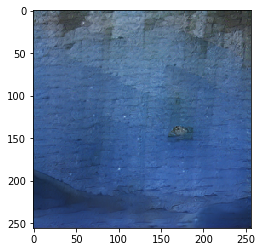

In [34]:
gen_example(dataset.wordtoix, algo, captions.CAPTIONS[i])

(u'The water falls into a stone pool.',
 <matplotlib.image.AxesImage at 0x7fb4a75c53d0>)

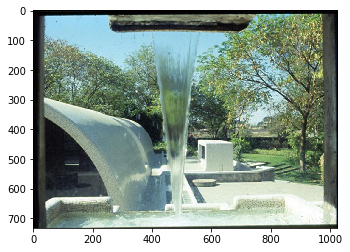

In [35]:
captions.CAPTIONS[i], plt.imshow(Image.open('../coco/images/'+captions.image_id[i]+'.jpg'))